In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

# Corrected import statements
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense

from tensorflow.keras.initializers import glorot_uniform

# Updated import statement
from tensorflow.keras.layers import Layer

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
path = 'C:/Users/Admin/Downloads/SoftCom_Pattern/Bengali/'

In [3]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [4]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:24]) # First 24 signatures in each folder are forrged
    orig_groups.append(images[24:]) # Next 24 signatures are genuine

In [5]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(110, 110)

In [6]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [7]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [8]:
# Quick check to confirm that there are 24 Forged signatures for each individual
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


#### Train-Validation-Test Split
* Signatures of 70 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [9]:
orig_train, orig_val, orig_test = orig_groups[:70], orig_groups[70:90], orig_groups[90:]
forg_train, forg_val, forg_test = forg_groups[:70], forg_groups[70:90], forg_groups[90:]

In [10]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [11]:
# All the images will be converted to the same size before processing
img_h, img_w = 256, 256

In [12]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

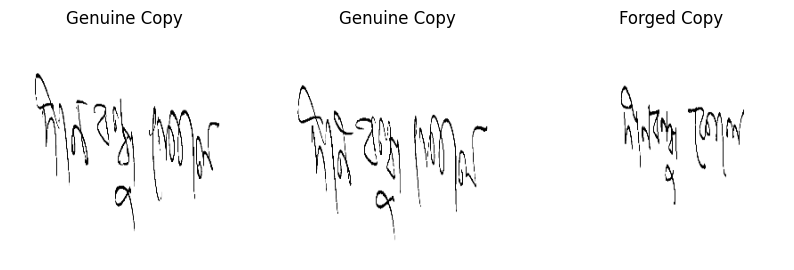

In [13]:
visualize_sample_signature()

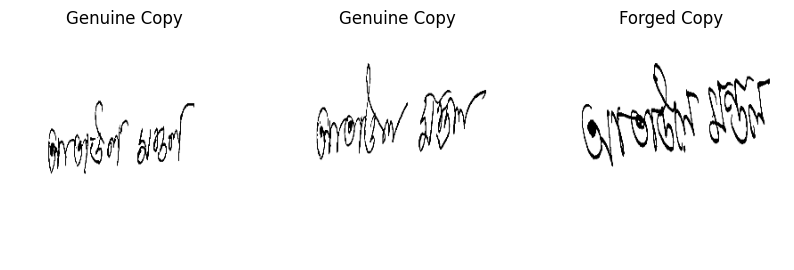

In [14]:
visualize_sample_signature()

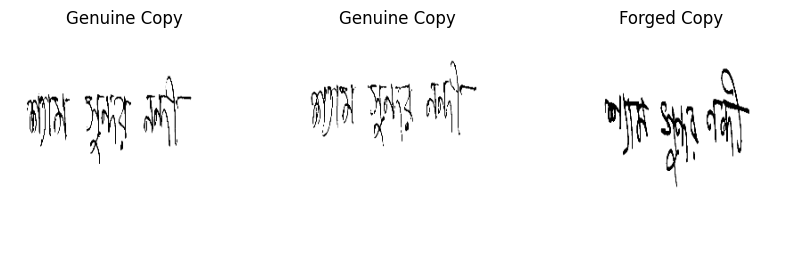

In [15]:
visualize_sample_signature()

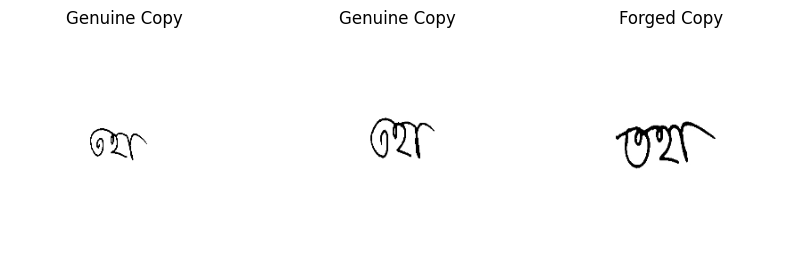

In [16]:
visualize_sample_signature()

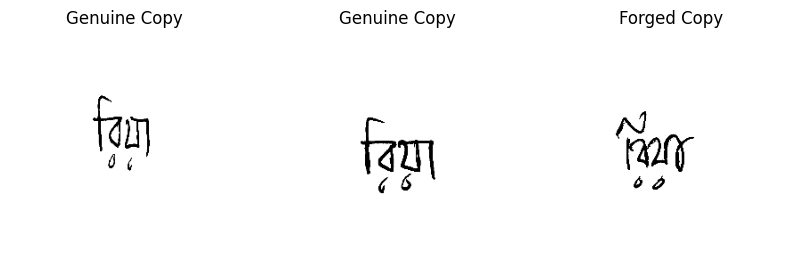

In [17]:
visualize_sample_signature()

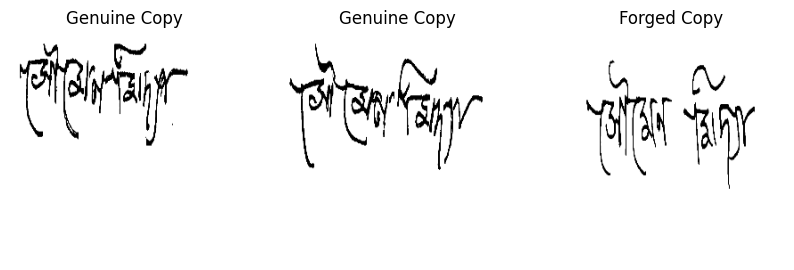

In [18]:
visualize_sample_signature()

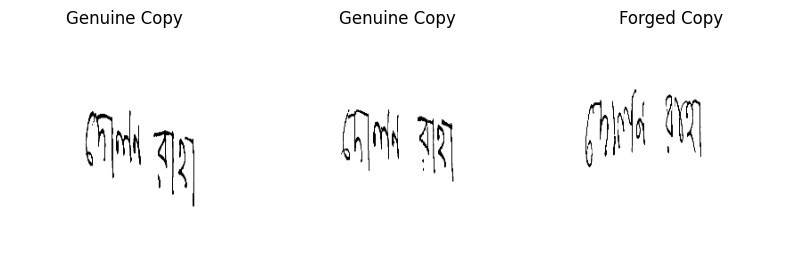

In [19]:
visualize_sample_signature()

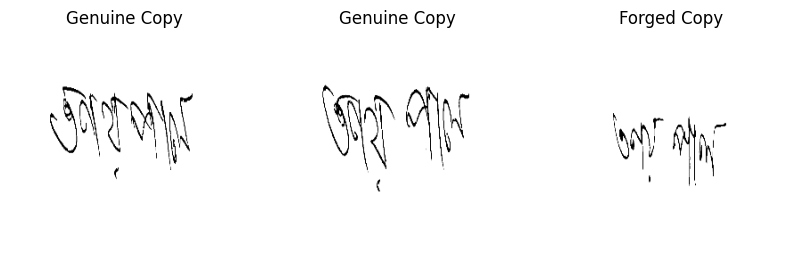

In [20]:
visualize_sample_signature()

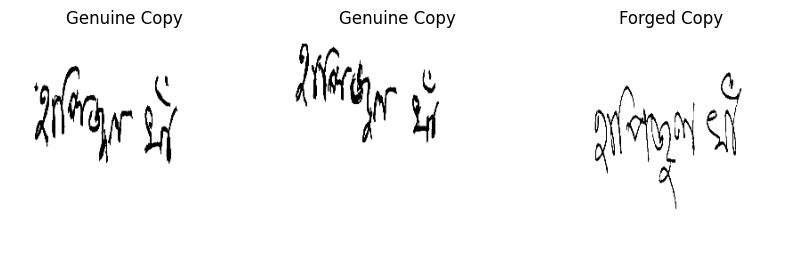

In [21]:
visualize_sample_signature()

In [35]:
def generate_batch(orig_groups, forg_groups, batch_size=128):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person. [n*(n-1)/2]
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 60 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 60 * 276 = 16560
        # Total number of Genuine-Forged pairs = 60 * 300 = 18000
        # Total no. of data points = 34560
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1] * len(orig_pairs)
        gen_for_labels = [0] * len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.

        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)

            # Check if images are empty before resizing
            if img1 is None or img2 is None:
                print("Empty image found. Skipping this pair.")
                continue  # Skip to the next iteration if images are empty

            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1)) for _ in range(2)]
                targets = np.zeros((batch_size,))


In [36]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [37]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [38]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.regularizers import l2

def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.5))

    seq.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.5))

    seq.add(Flatten(name='flatten'))
    seq.add(Dense(256, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))

    seq.add(Dense(64, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))

    return seq

# Example usage:
input_shape = (224, 224, 3)  # Adjust the input shape according to your data
base_network = create_base_network_signet(input_shape)
base_network.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_6 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [40]:
input_shape=(img_h, img_w, 1)

In [41]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)


In [42]:
batch_sz = 64
num_train_samples = 276*70 + 276*70
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(38640, 11520, 11520)

In [43]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [44]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('C:/Users/Admin/Downloads/SoftCom_Pattern/weight/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle

# Assuming that the generate_batch function and other necessary imports are available

# Define parameters
batch_size = 64
num_epochs = 5  # Adjust as needed

# Optionally, you can shuffle the data before each epoch
orig_train, forg_train = shuffle(orig_train, forg_train)

# # Create a ModelCheckpoint callback to save the best model
# checkpoint = ModelCheckpoint("your_model_checkpoint.h5", save_best_only=True)

# Initialize the generators
train_batch_generator = generate_batch(orig_train, forg_train, batch_size)
val_batch_generator = generate_batch(orig_val, forg_val, batch_size)

# Define the number of batches you want to generate
num_train_batches = num_train_samples // batch_size
num_val_batches = num_val_samples // batch_size


In [47]:
# Use model.fit for training
history = model.fit(
    train_batch_generator,
    steps_per_epoch=num_train_batches,
    epochs=num_epochs,
    validation_data=val_batch_generator,
    validation_steps=num_val_batches,
    callbacks=callbacks,
)


Epoch 1/5
603/603 [==============================] - ETA: 0s - loss: nan
Epoch 1: saving model to C:/Users/Admin/Downloads/SoftCom_Pattern/weight\signet-bhsig260-001.h5
603/603 [==============================] - 5274s 9s/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/5
  1/603 [..............................] - ETA: 2:00:39 - loss: nan

KeyboardInterrupt: 

#### After observing continuous fall in validation accuracy, I interrupted the training manually

In [48]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [50]:
model.load_weights('C:/Users/Admin/Downloads/SoftCom_Pattern/weight/signet-bhsig260-{epoch:03d}.h5')

In [51]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


In [52]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.5, 0.0)

#### Accuracy = 81.71% and Threshold = 0.55
Thus if the differnce score is less than 0.55, we predict the test image as Genuine and if the difference score is greater than 0.55, we predict it to be as forged

#### Below we see some sample results

In [53]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

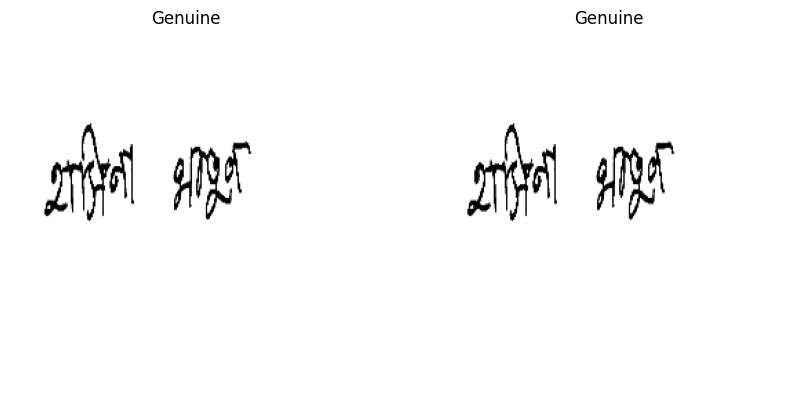

1/1 [==============================] - 0s 47ms/step
Difference Score =  0.0
Its a Genuine Signature


In [54]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

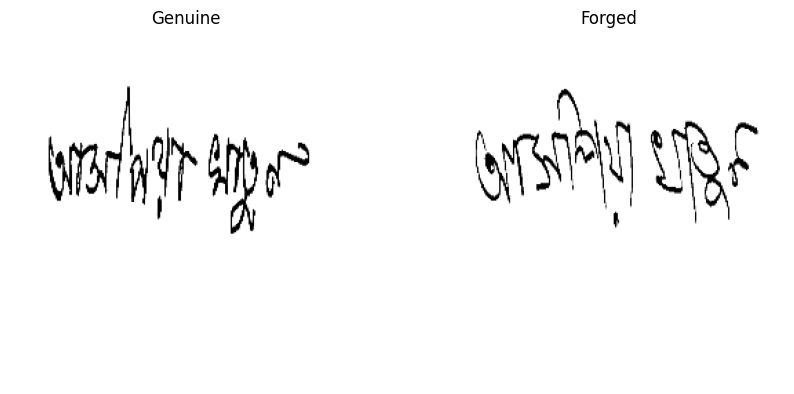

1/1 [==============================] - 0s 47ms/step
Difference Score =  0.0
Its a Genuine Signature


In [55]:
predict_score()

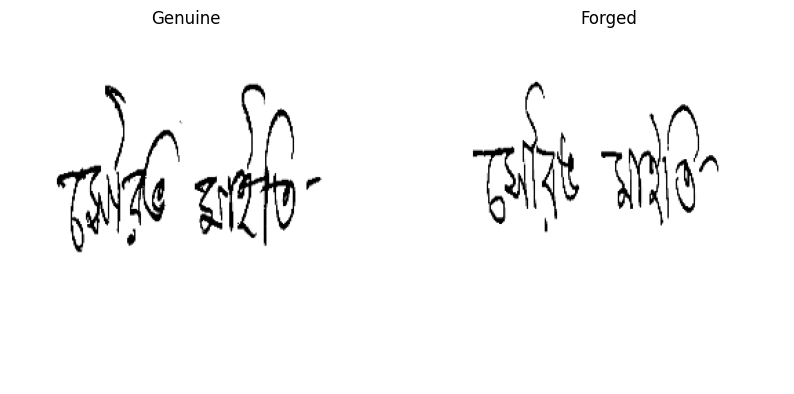

1/1 [==============================] - 0s 47ms/step
Difference Score =  0.0
Its a Genuine Signature


In [56]:
predict_score()

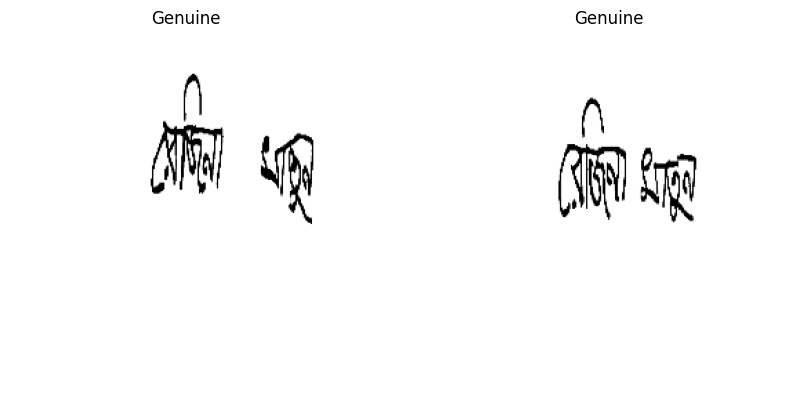

1/1 [==============================] - 0s 47ms/step
Difference Score =  0.0
Its a Genuine Signature


In [57]:
predict_score()

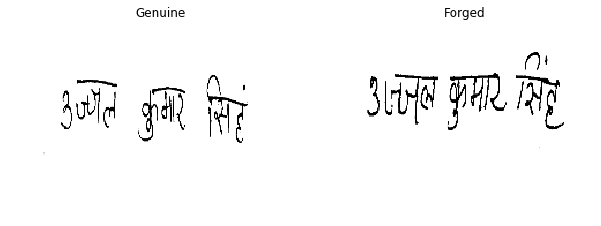

Difference Score =  0.75105387
Its a Forged Signature


In [81]:
predict_score()

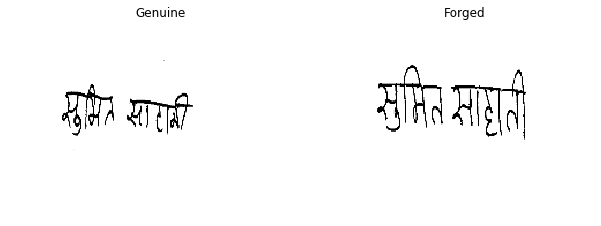

Difference Score =  1.407155
Its a Forged Signature


In [82]:
predict_score()

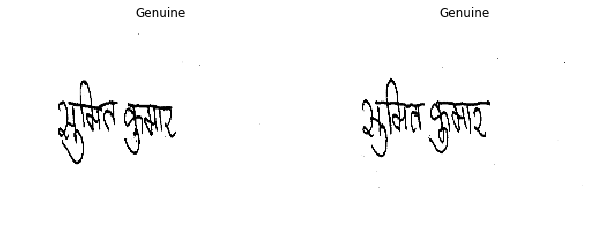

Difference Score =  0.20205197
Its a Genuine Signature


In [83]:
predict_score()

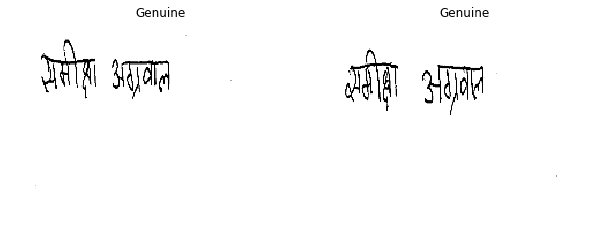

Difference Score =  0.062546685
Its a Genuine Signature


In [84]:
predict_score()

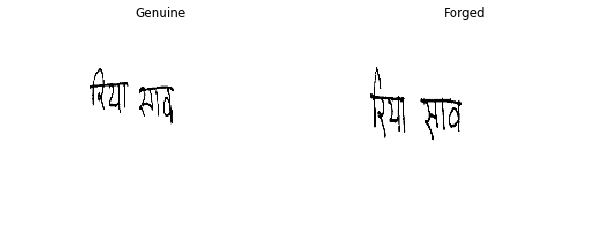

Difference Score =  1.0295221
Its a Forged Signature


In [85]:
predict_score()

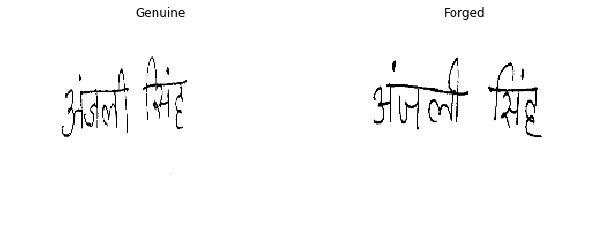

Difference Score =  0.6782455
Its a Forged Signature


In [86]:
predict_score()

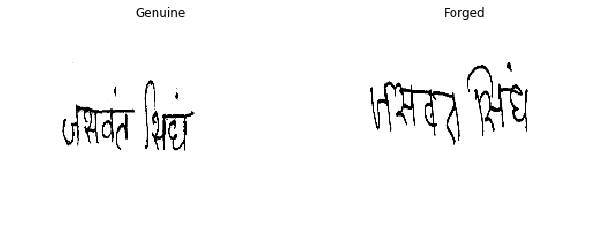

Difference Score =  1.3220205
Its a Forged Signature


In [87]:
predict_score()

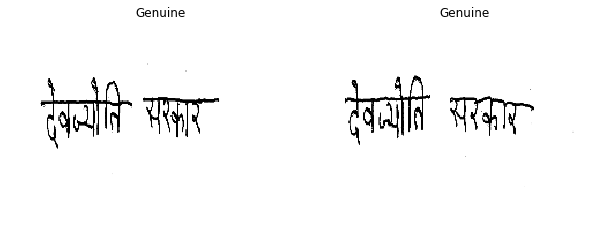

Difference Score =  0.75327426
Its a Forged Signature


In [88]:
predict_score()

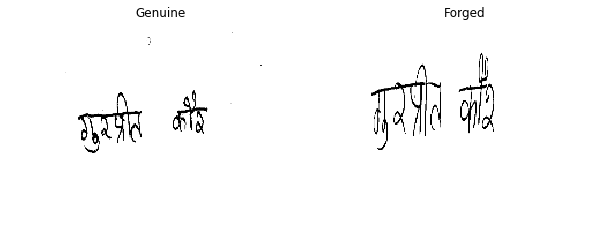

Difference Score =  1.198973
Its a Forged Signature


In [89]:
predict_score()

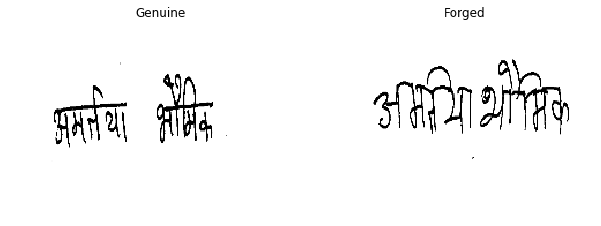

Difference Score =  1.0658648
Its a Forged Signature


In [90]:
predict_score()

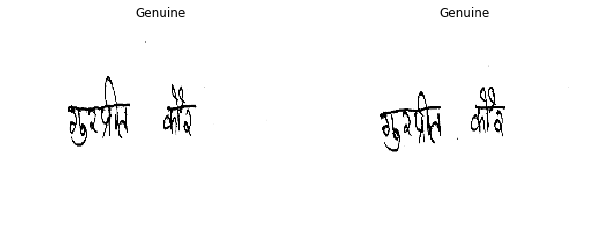

Difference Score =  0.028276775
Its a Genuine Signature


In [91]:
predict_score()

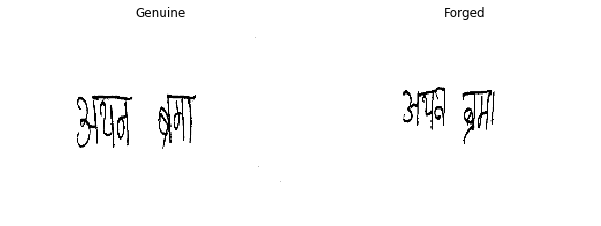

Difference Score =  0.14532466
Its a Genuine Signature


In [92]:
predict_score()

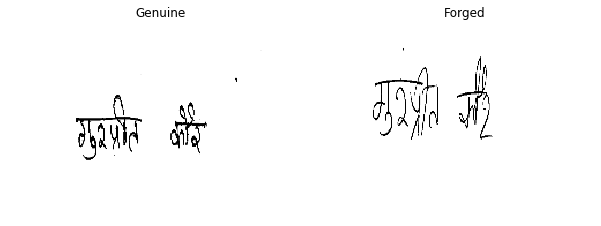

Difference Score =  0.42529866
Its a Genuine Signature


In [93]:
predict_score()

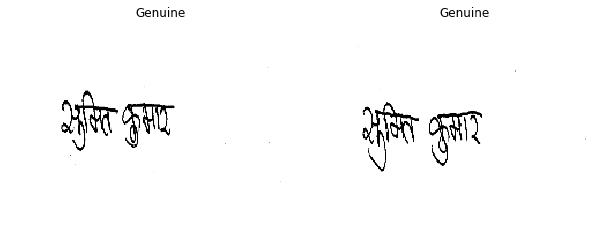

Difference Score =  0.5412746
Its a Genuine Signature


In [94]:
predict_score()

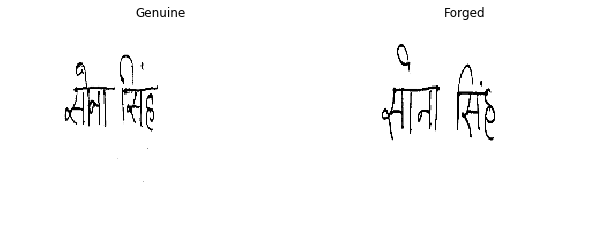

Difference Score =  0.7716991
Its a Forged Signature


In [95]:
predict_score()

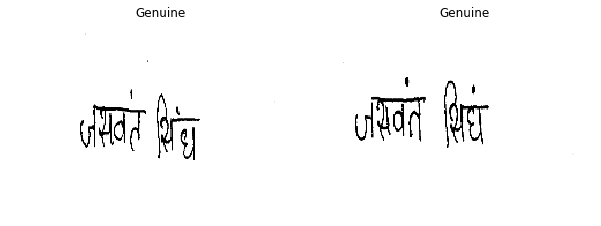

Difference Score =  0.22233899
Its a Genuine Signature


In [96]:
predict_score()

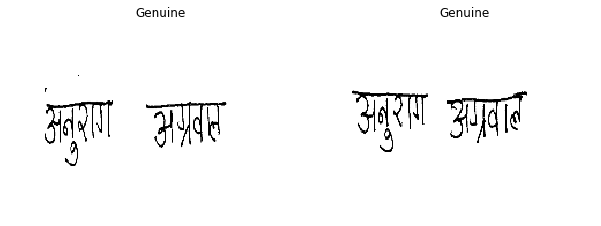

Difference Score =  0.4042654
Its a Genuine Signature


In [97]:
predict_score()

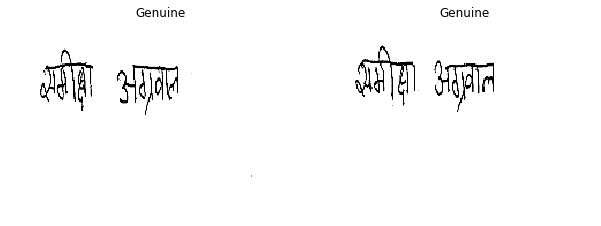

Difference Score =  0.0046115727
Its a Genuine Signature


In [98]:
predict_score()

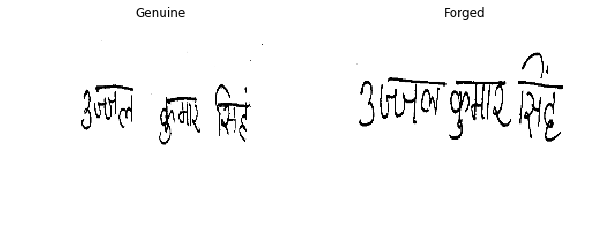

Difference Score =  0.9337214
Its a Forged Signature


In [99]:
predict_score()

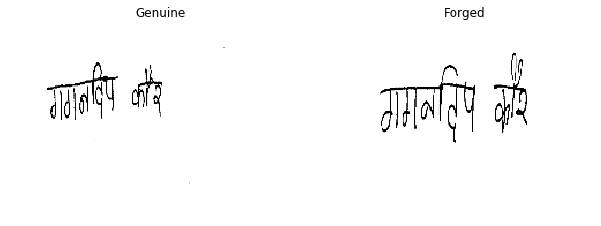

Difference Score =  1.2939676
Its a Forged Signature


In [100]:
predict_score()

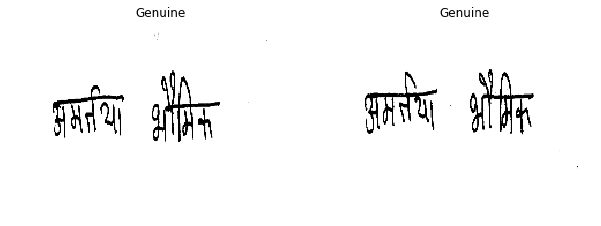

Difference Score =  0.12535787
Its a Genuine Signature


In [101]:
predict_score()

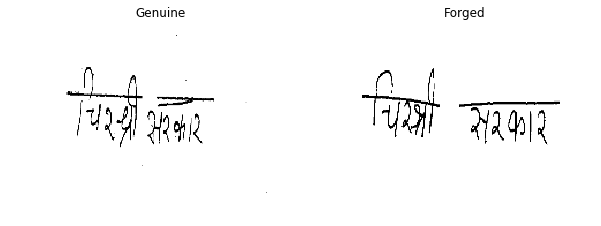

Difference Score =  1.5029047
Its a Forged Signature


In [102]:
predict_score()

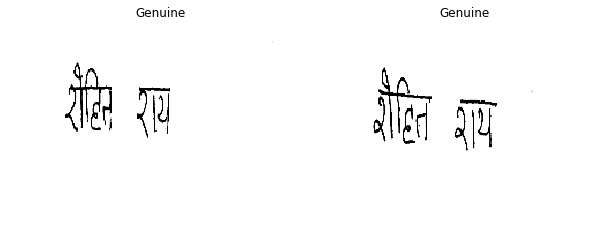

Difference Score =  0.42879045
Its a Genuine Signature


In [103]:
predict_score()

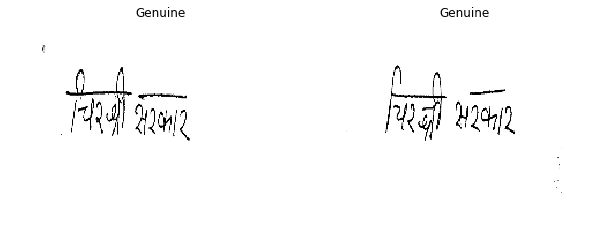

Difference Score =  0.23687324
Its a Genuine Signature


In [104]:
predict_score()

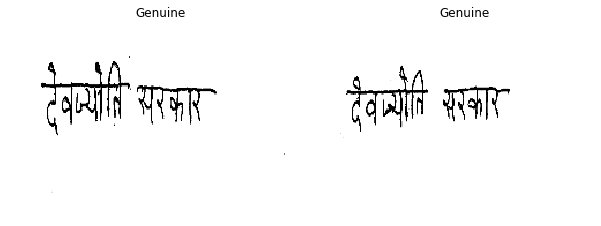

Difference Score =  0.610156
Its a Forged Signature


In [105]:
predict_score()

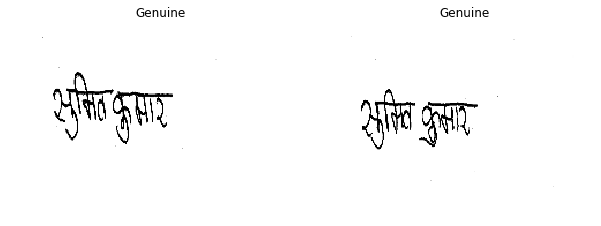

Difference Score =  0.26007065
Its a Genuine Signature


In [106]:
predict_score()

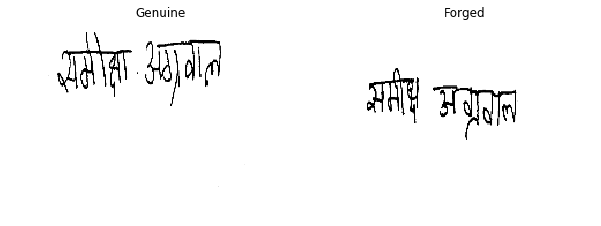

Difference Score =  0.7205819
Its a Forged Signature


In [107]:
predict_score()

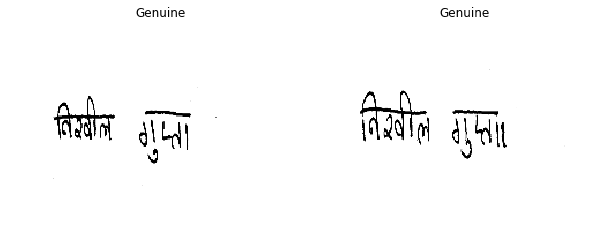

Difference Score =  0.25164193
Its a Genuine Signature


In [108]:
predict_score()

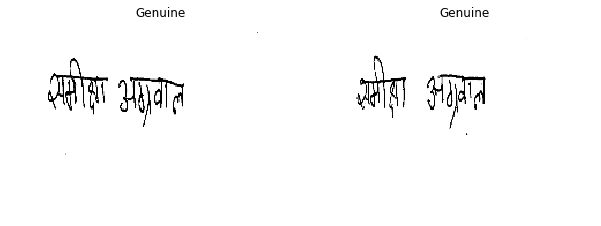

Difference Score =  0.38825786
Its a Genuine Signature


In [109]:
predict_score()

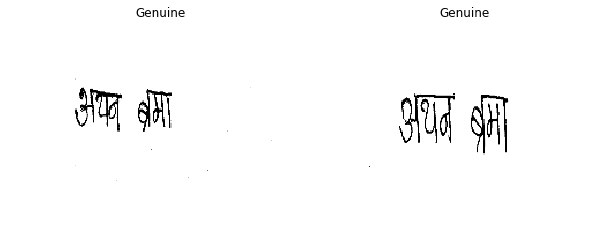

Difference Score =  0.676633
Its a Forged Signature


In [110]:
predict_score()

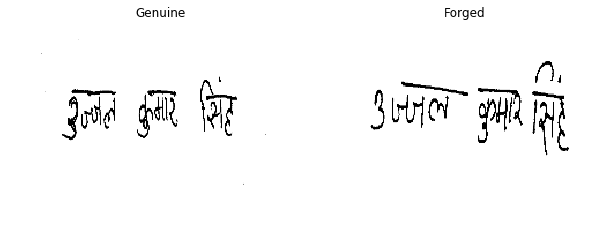

Difference Score =  1.0987293
Its a Forged Signature


In [111]:
predict_score()

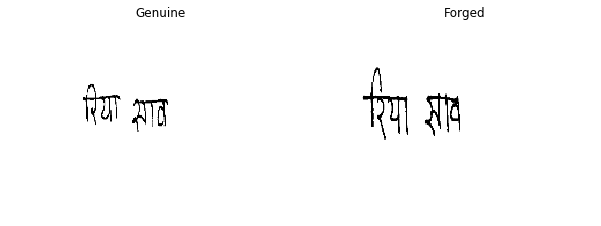

Difference Score =  0.8815795
Its a Forged Signature


In [112]:
predict_score()

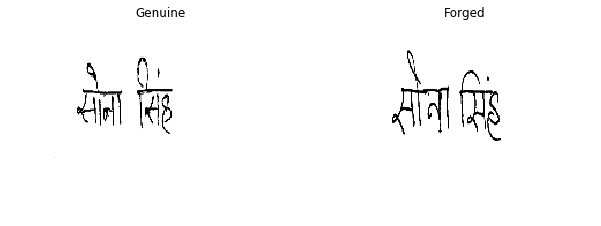

Difference Score =  1.207816
Its a Forged Signature


In [113]:
predict_score()

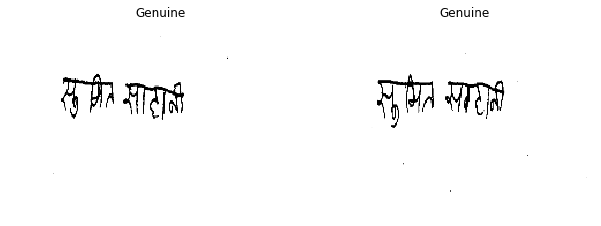

Difference Score =  0.1395914
Its a Genuine Signature


In [114]:
predict_score()

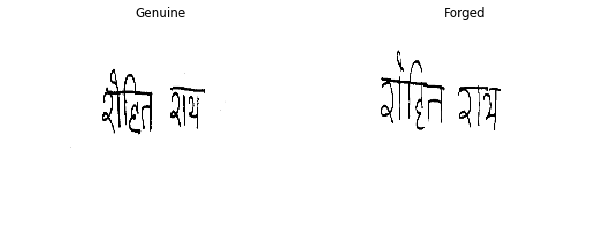

Difference Score =  0.5675886
Its a Forged Signature


In [115]:
predict_score()

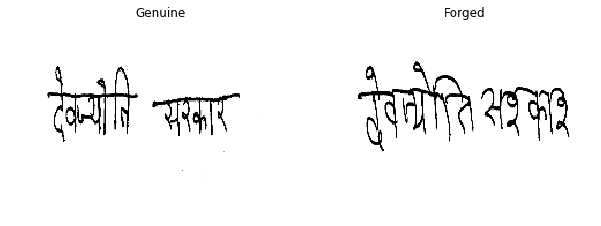

Difference Score =  0.98273134
Its a Forged Signature


In [116]:
predict_score()

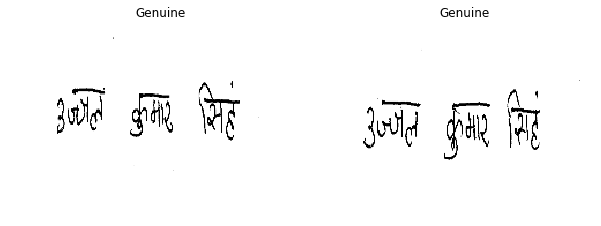

Difference Score =  0.0066289324
Its a Genuine Signature


In [117]:
predict_score()

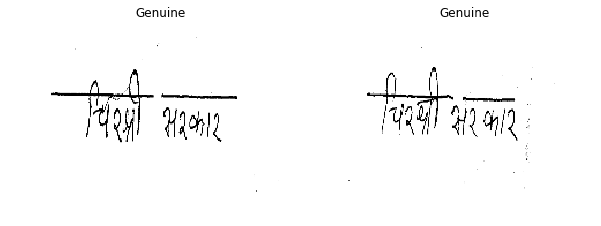

Difference Score =  0.119971395
Its a Genuine Signature


In [118]:
predict_score()

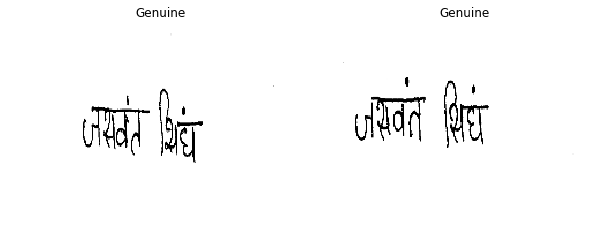

Difference Score =  0.4253973
Its a Genuine Signature


In [119]:
predict_score()

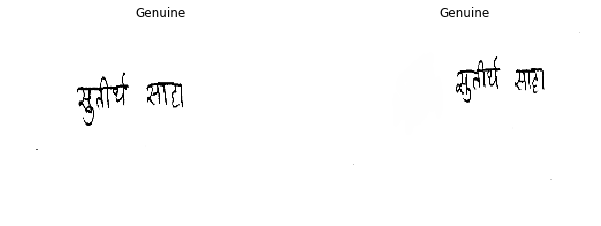

Difference Score =  0.057567514
Its a Genuine Signature


In [120]:
predict_score()